<a href="https://www.kaggle.com/code/klyushnik/s5-e8-0-96874?scriptVersionId=256602293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


# Kaggle Playground Series 2025: Bank Term Deposit Prediction

## Competition Overview
Welcome to the **2025 Kaggle Playground Series**! This competition follows the tradition of providing approachable yet interesting datasets to help the community practice and hone their machine learning skills. Expect a new challenge every month!

### Objective
**Goal**: Predict whether a client will subscribe to a term deposit offered by a bank.  
This is a **binary classification problem**, where you need to estimate the probability of a "yes" (subscription) outcome.

### Evaluation Metric
Submissions are evaluated using the **Area Under the ROC Curve (ROC AUC)** between the predicted probabilities and the observed target.  
- **Higher AUC** = Better model performance.  
- The metric ranges from 0 to 1, where 1 indicates perfect prediction.

### Submission Format
Create a CSV file named `submission.csv` with the following structure:  
```csv
id,y
750000,0.5
750001,0.5
750002,0.5
...

# Imports

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from scipy.optimize import minimize
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import warnings

# from imblearn.over_sampling import (
# ADASYN, 
# SMOTE, 
# KMeansSMOTE)

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    LabelEncoder,
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    chi2,
    SequentialFeatureSelector,
)
from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    KFold,
    train_test_split,
    cross_validate,
)
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    classification_report,
    roc_auc_score
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from keras import backend as K
import keras_tuner
from keras_tuner import RandomSearch, Hyperband

from pathlib import Path
import logging
from functools import partial

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder, MEstimateEncoder

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

import logging

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

# Setting

In [5]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

def replace_outliers_with_mean(df, threshold=3):

    df_clean = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit')) 
        
        mean_val = df[col][z_scores <= threshold].mean()
        
        df_clean[col] = np.where(z_scores > threshold, mean_val, df[col])
        
    return df_clean


# Data

In [6]:
train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

display(train.shape, test.shape)

display(train.info())
display(test.info())

test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

display(train.head(5))
display(test.head(5))

display(train.describe().T)

duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

duplicates = test.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

for col in test.columns:
    pct_missing = np.mean(test[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

(750000, 18)

(250000, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


None

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0
y,750000.0,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0


Number of duplicates: 0
age - 0%
job - 0%
marital - 0%
education - 0%
default - 0%
balance - 0%
housing - 0%
loan - 0%
contact - 0%
day - 0%
month - 0%
duration - 0%
campaign - 0%
pdays - 0%
previous - 0%
poutcome - 0%
y - 0%
Number of duplicates: 0
age - 0%
job - 0%
marital - 0%
education - 0%
default - 0%
balance - 0%
housing - 0%
loan - 0%
contact - 0%
day - 0%
month - 0%
duration - 0%
campaign - 0%
pdays - 0%
previous - 0%
poutcome - 0%
Memory usage size: before 97.2749 Mb - after 61.5121 Mb (36.8%).
Memory usage size: before 30.5177 Mb - after 20.2657 Mb (33.6%).


# Exploratory Data Analysis

## Numerical feature

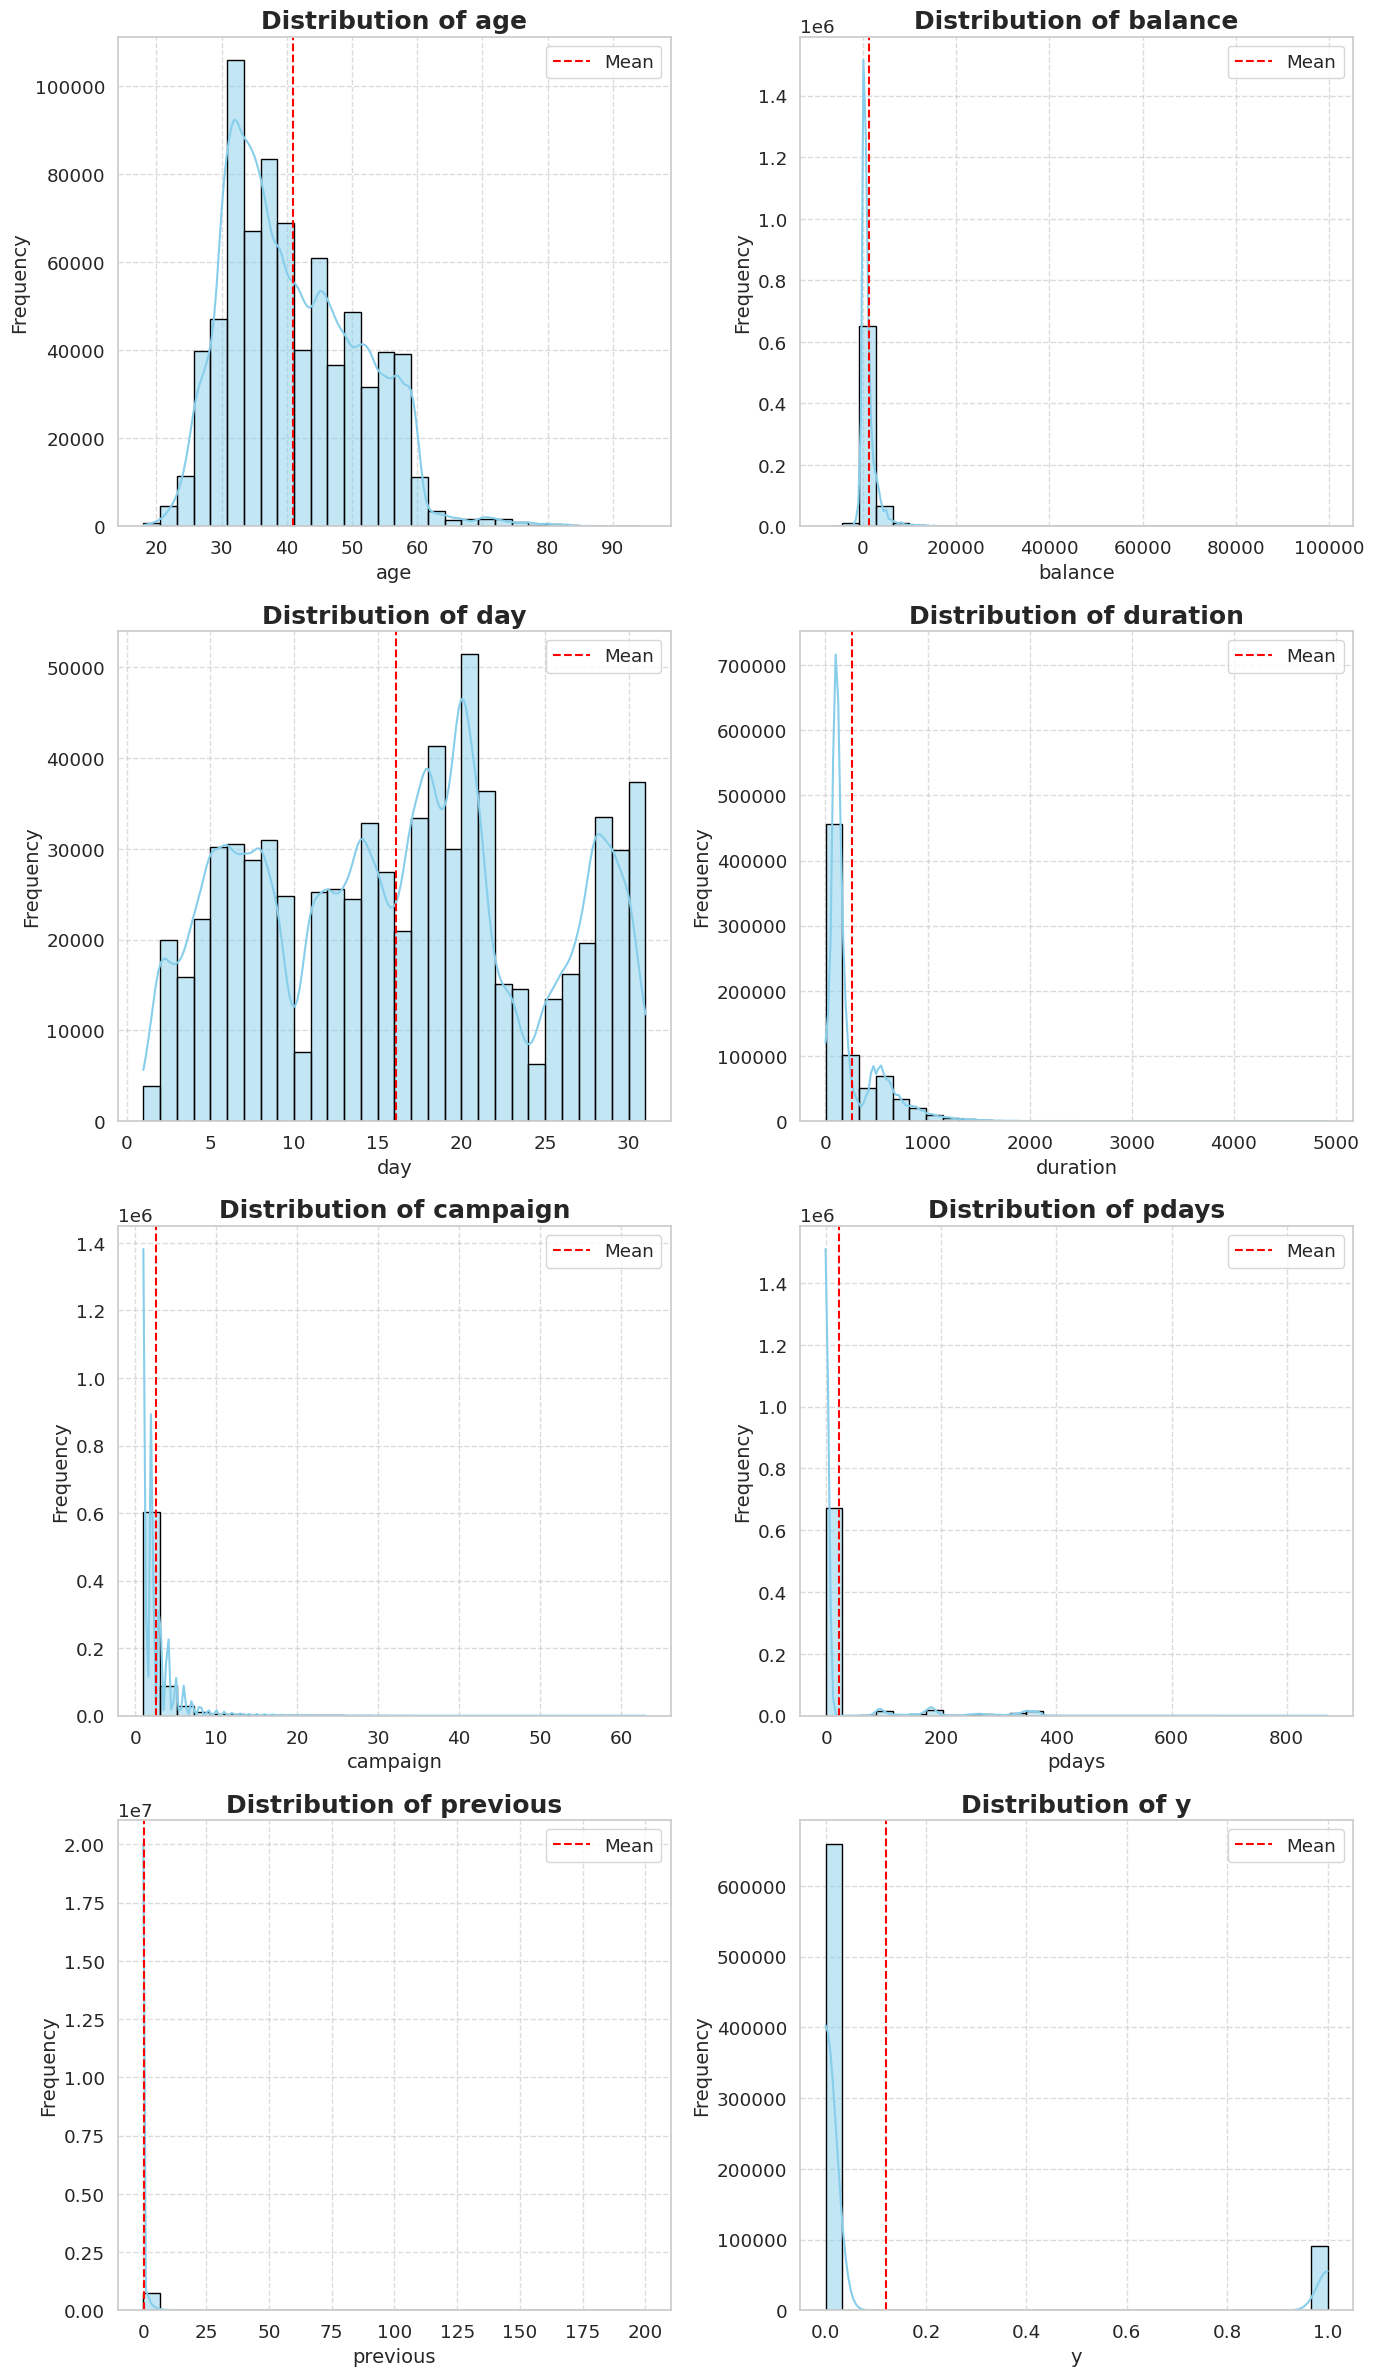

In [7]:
plot_numerical_features(train)

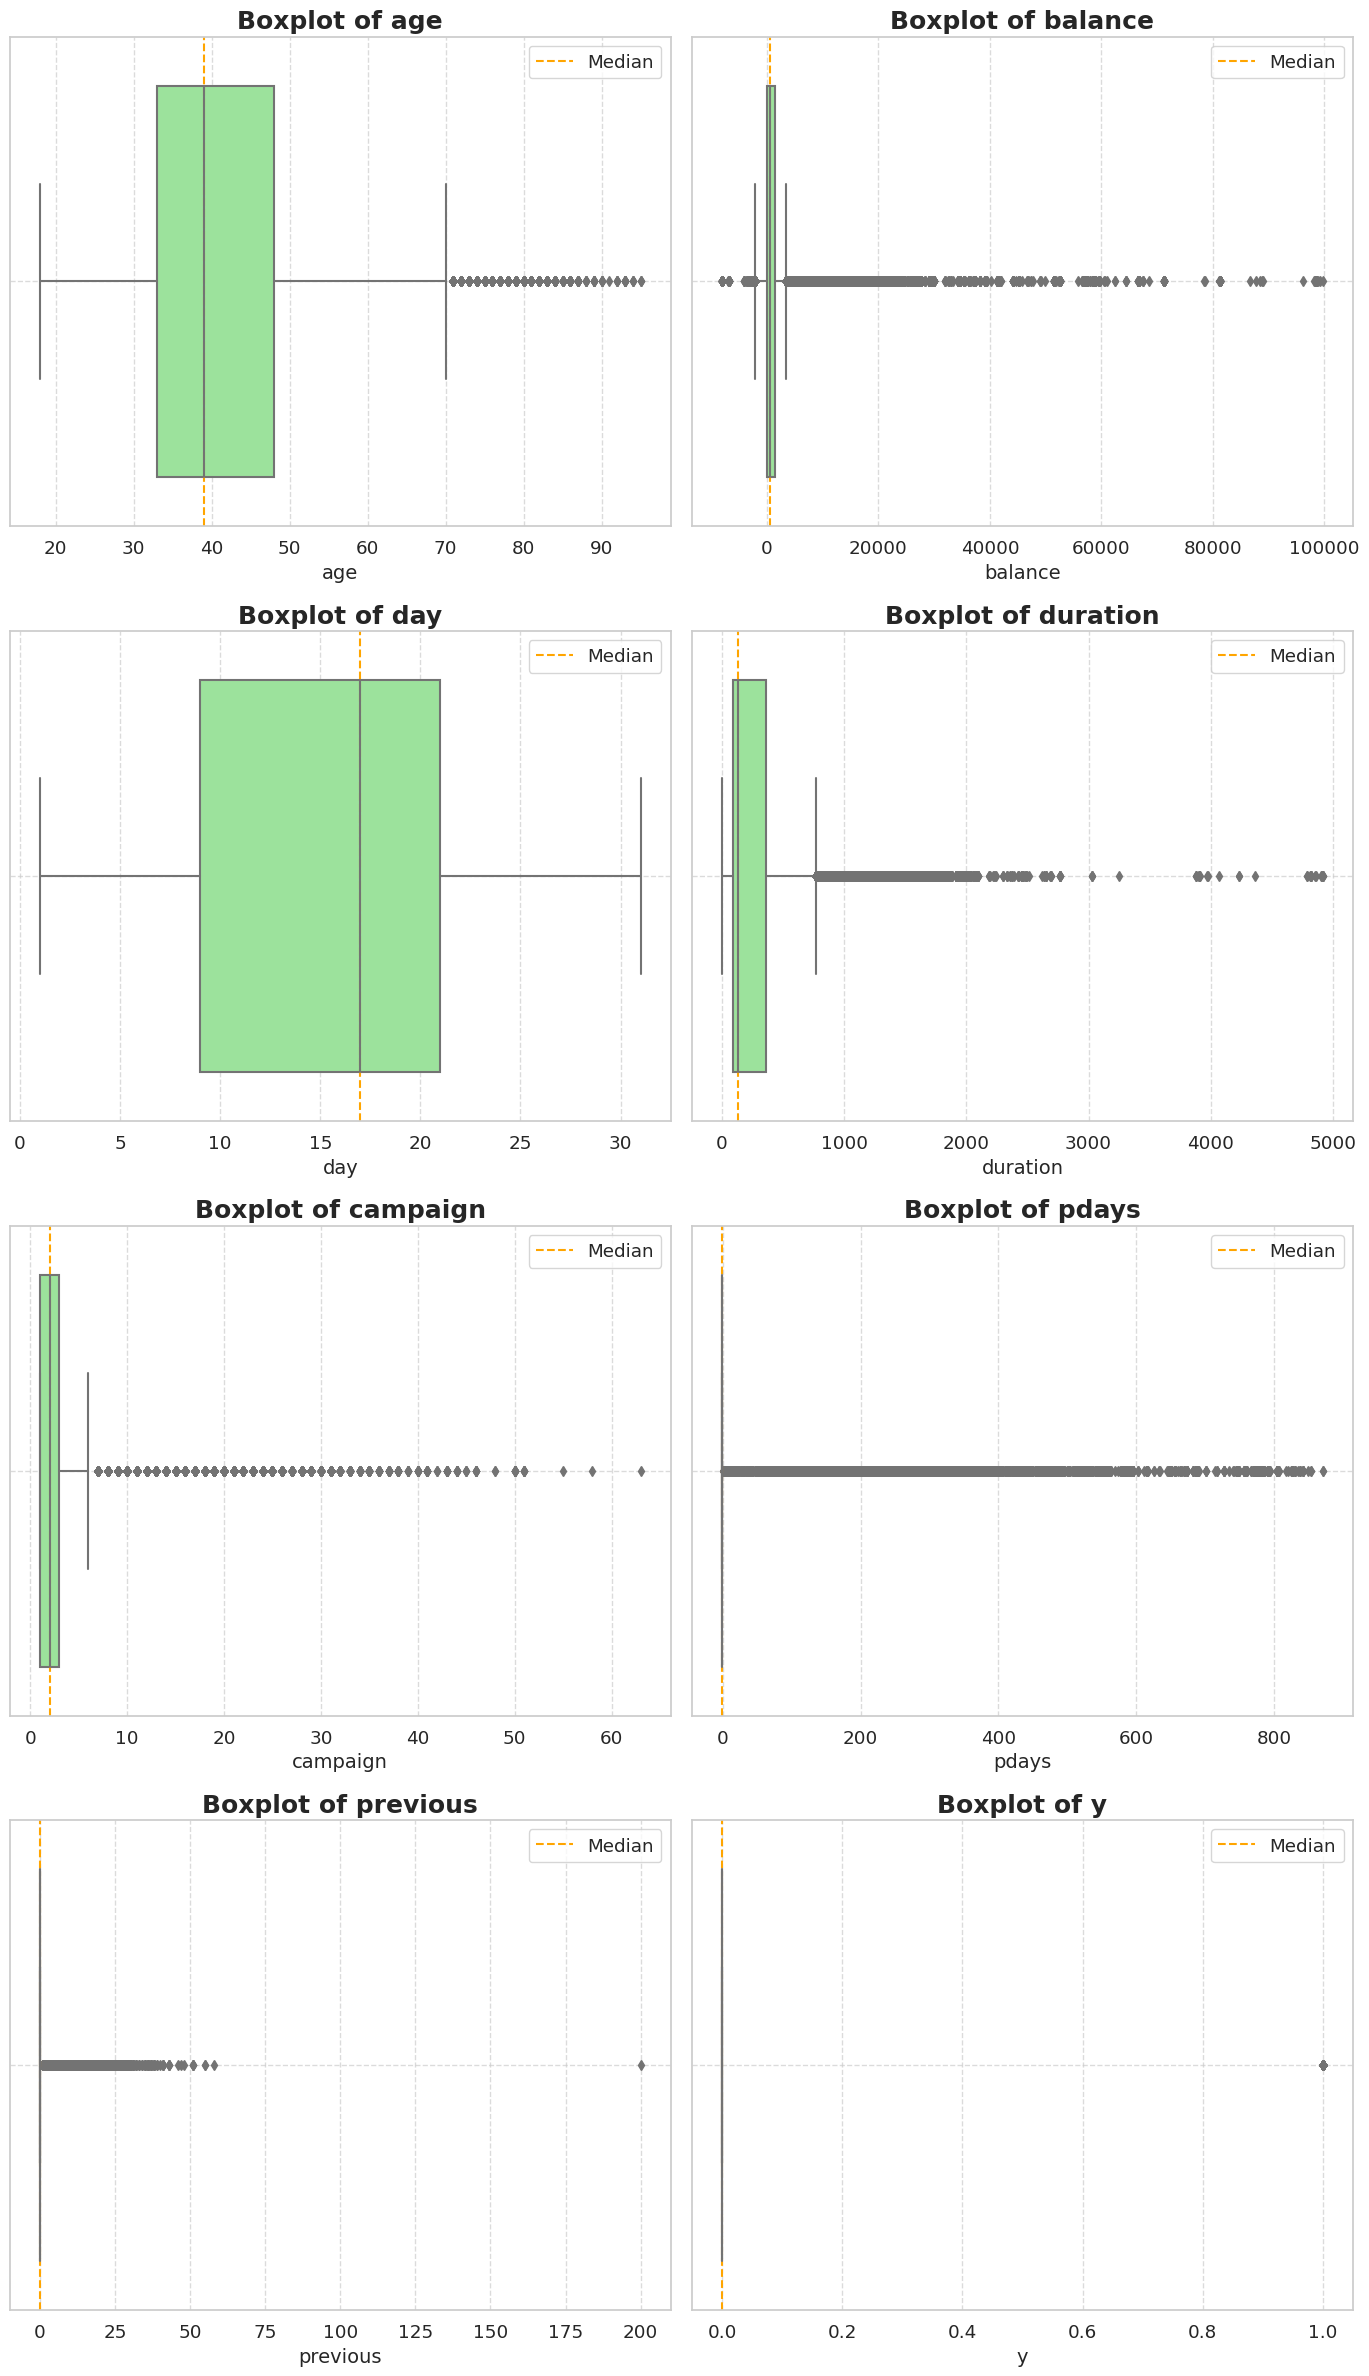

In [8]:
plot_numerical_boxplots(train)

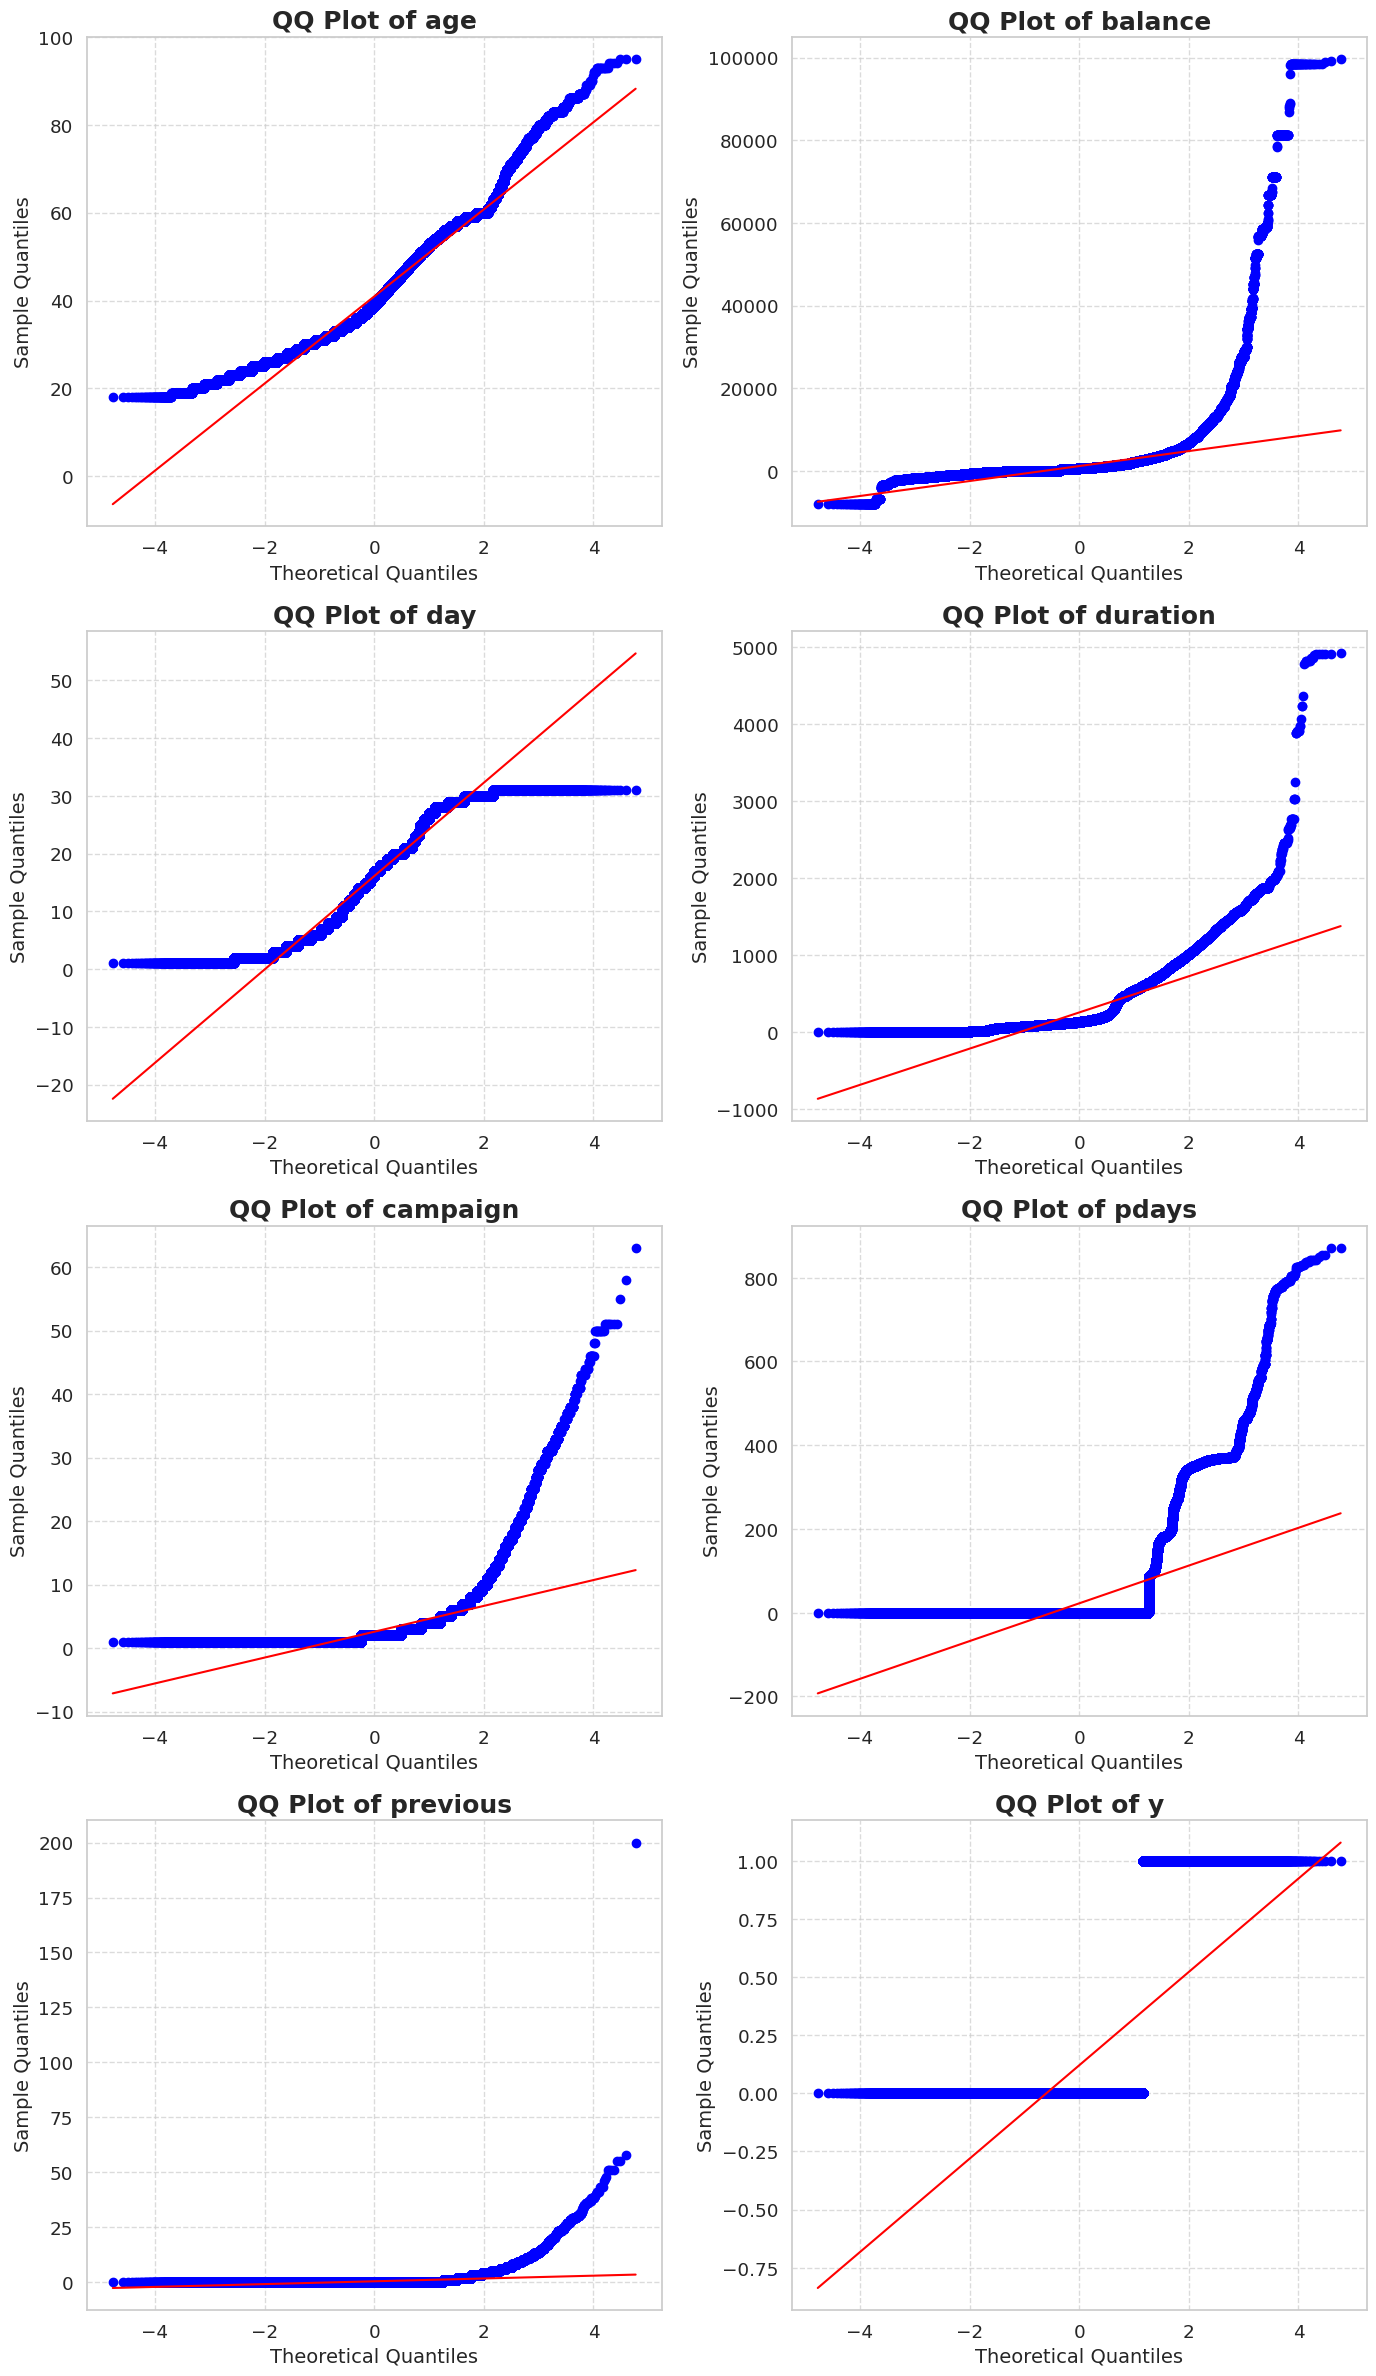

In [9]:
plot_qq_plot(train)

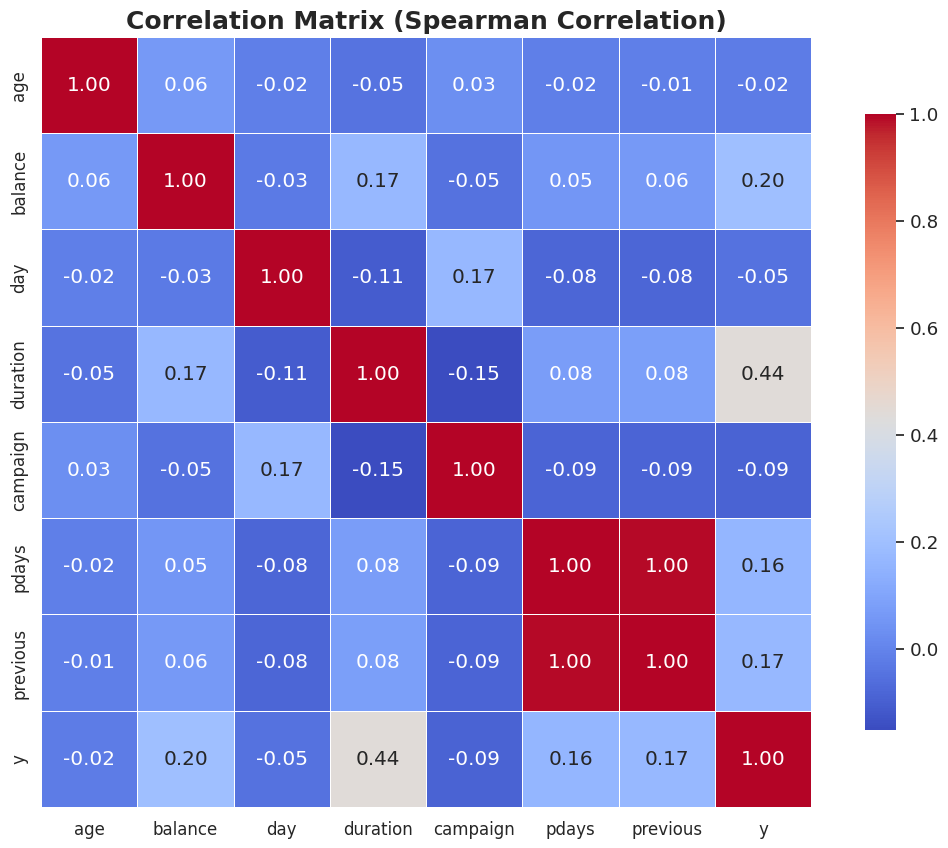

In [10]:
plot_correlation_matrix(train)

In [11]:
X = sm.add_constant(train.select_dtypes(include=[np.number]).iloc [:, 1:])

VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

   Variable       VIF
0     const  6.730211
1   balance  1.019200
2       day  1.040917
3  duration  1.379310
4  campaign  1.042299
5     pdays  1.472652
6  previous  1.474539
7         y  1.397554


## Categorical features

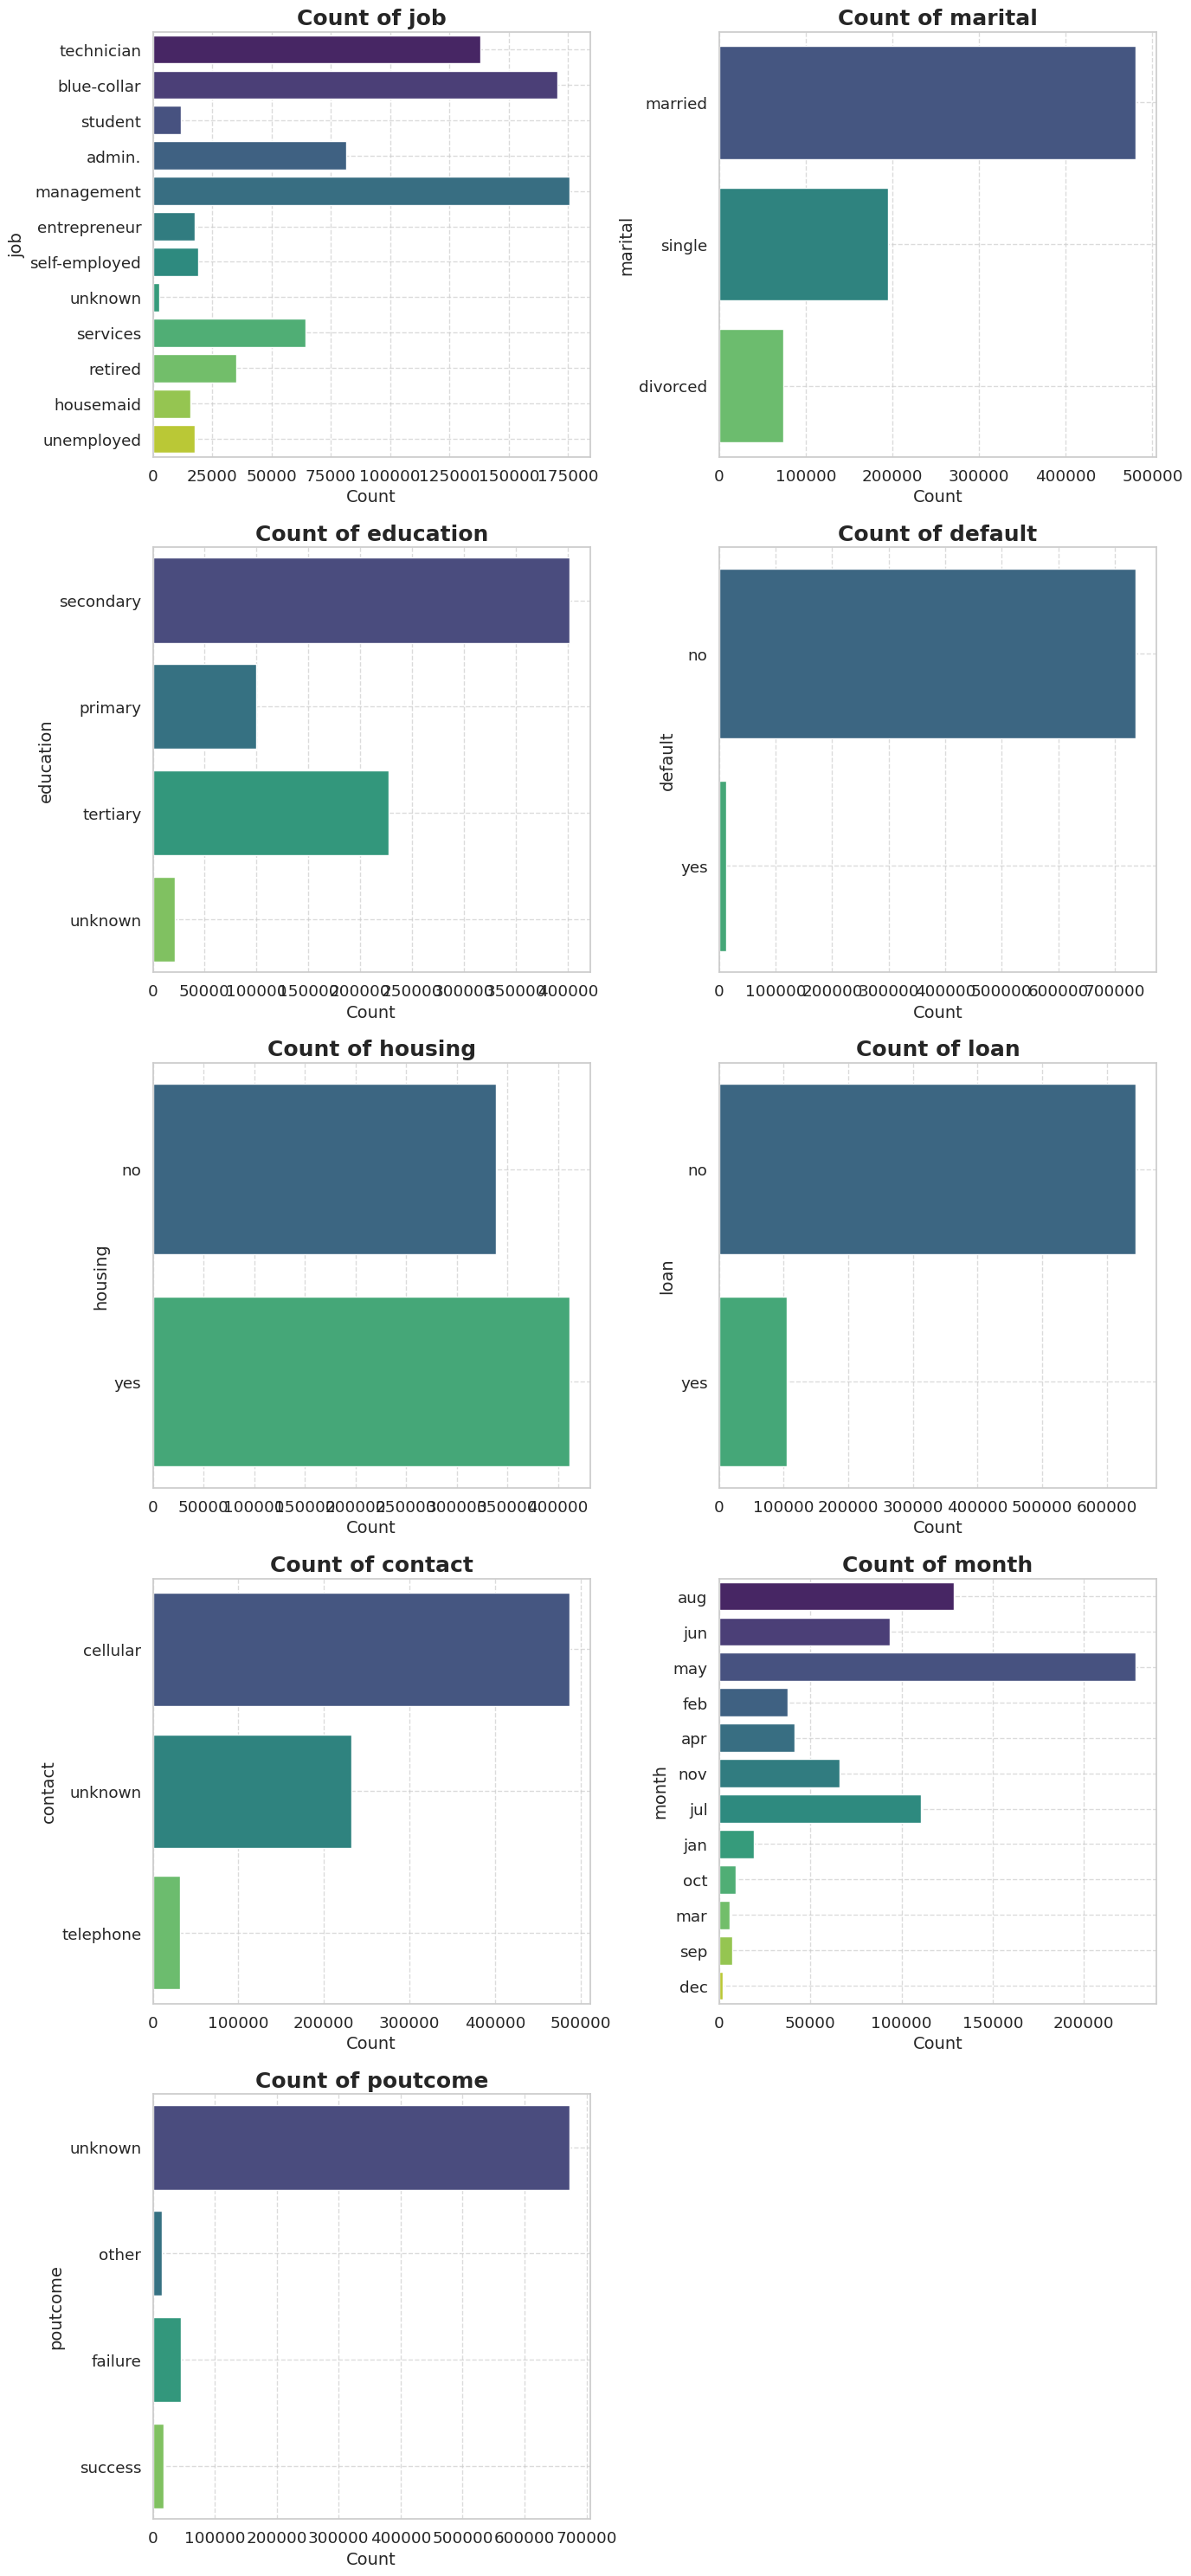

In [12]:
plot_categorical_features(train)

# New features

## Temporal 

In [13]:
train['season'] = train['month'].map({
    'dec': 'winter', 'jan': 'winter', 'feb': 'winter',
    'mar': 'spring', 'apr': 'spring', 'may': 'spring',
    'jun': 'summer', 'jul': 'summer', 'aug': 'summer',
    'sep': 'autumn', 'oct': 'autumn', 'nov': 'autumn'
})

test['season'] = test['month'].map({
    'dec': 'winter', 'jan': 'winter', 'feb': 'winter',
    'mar': 'spring', 'apr': 'spring', 'may': 'spring',
    'jun': 'summer', 'jul': 'summer', 'aug': 'summer',
    'sep': 'autumn', 'oct': 'autumn', 'nov': 'autumn'
})

display(train.shape, test.shape)

display(train.info())
display(test.info())

(750000, 18)

(250000, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int8  
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int32 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int8  
 10  month      750000 non-null  object
 11  duration   750000 non-null  int16 
 12  campaign   750000 non-null  int8  
 13  pdays      750000 non-null  int16 
 14  previous   750000 non-null  int16 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int8  
 17  season     750000 non-null  object
dtypes: int16(3), int32(1), int8(4), object(10)
memory usage: 67.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        250000 non-null  int8  
 1   job        250000 non-null  object
 2   marital    250000 non-null  object
 3   education  250000 non-null  object
 4   default    250000 non-null  object
 5   balance    250000 non-null  int32 
 6   housing    250000 non-null  object
 7   loan       250000 non-null  object
 8   contact    250000 non-null  object
 9   day        250000 non-null  int8  
 10  month      250000 non-null  object
 11  duration   250000 non-null  int16 
 12  campaign   250000 non-null  int8  
 13  pdays      250000 non-null  int16 
 14  previous   250000 non-null  int16 
 15  poutcome   250000 non-null  object
 16  season     250000 non-null  object
dtypes: int16(3), int32(1), int8(3), object(10)
memory usage: 22.2+ MB


None

## Financial

In [14]:
train['is_balance_negative'] = (train['balance'] < 0).astype(int)
train['debt_ratio'] = train['balance'] / train.groupby('job')['balance'].transform('mean')
train['contact_duration_minutes'] = train['duration'] / 60
train['contact_efficiency'] = train['duration'] / (train['campaign'] + 1)

test['is_balance_negative'] = (test['balance'] < 0).astype(int)
test['debt_ratio'] = test['balance'] / test.groupby('job')['balance'].transform('mean')
test['contact_duration_minutes'] = test['duration'] / 60
test['contact_efficiency'] =test['duration'] / (test['campaign'] + 1)

display(train.shape, test.shape)

(750000, 22)

(250000, 21)

## Others

In [15]:
train['previous_contact_ratio'] = train['previous'] / (train['campaign'] + train['previous'] + 1e-6)
train['is_repeated_contact'] = (train['previous'] > 0).astype(int)
train['has_unknown_contact'] = (train['contact'] == 'unknown').astype(int)
train['poutcome_success'] = (train['poutcome'] == 'success').astype(int)

test['previous_contact_ratio'] = test['previous'] / (test['campaign'] + test['previous'] + 1e-6)
test['is_repeated_contact'] = (test['previous'] > 0).astype(int)
test['has_unknown_contact'] = (test['contact'] == 'unknown').astype(int)
test['poutcome_success'] = (test['poutcome'] == 'success').astype(int)

display(train.shape, test.shape)

(750000, 26)

(250000, 25)

In [16]:
job_freq = train['job'].value_counts(normalize=True).to_dict()
train['job_freq'] = train['job'].map(job_freq)

job_freq_test = test['job'].value_counts(normalize=True).to_dict()
test['job_freq'] = test['job'].map(job_freq)

In [17]:
train['education_level'] = train['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})

test['education_level'] = test['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})

In [18]:
display(train.shape, test.shape)

display(train.info())
display(test.info())

display(train.head(5))
display(test.head(5))

display(train.describe().T)

(750000, 28)

(250000, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       750000 non-null  int8   
 1   job                       750000 non-null  object 
 2   marital                   750000 non-null  object 
 3   education                 750000 non-null  object 
 4   default                   750000 non-null  object 
 5   balance                   750000 non-null  int32  
 6   housing                   750000 non-null  object 
 7   loan                      750000 non-null  object 
 8   contact                   750000 non-null  object 
 9   day                       750000 non-null  int8   
 10  month                     750000 non-null  object 
 11  duration                  750000 non-null  int16  
 12  campaign                  750000 non-null  int8   
 13  pdays                     750000 non-null  i

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       250000 non-null  int8   
 1   job                       250000 non-null  object 
 2   marital                   250000 non-null  object 
 3   education                 250000 non-null  object 
 4   default                   250000 non-null  object 
 5   balance                   250000 non-null  int32  
 6   housing                   250000 non-null  object 
 7   loan                      250000 non-null  object 
 8   contact                   250000 non-null  object 
 9   day                       250000 non-null  int8   
 10  month                     250000 non-null  object 
 11  duration                  250000 non-null  int16  
 12  campaign                  250000 non-null  int8   
 13  pdays                     250000 non-null  i

None

,age,job,marital,education,default,balance,housing,loan,contact,day,...,is_balance_negative,debt_ratio,contact_duration_minutes,contact_efficiency,previous_contact_ratio,is_repeated_contact,has_unknown_contact,poutcome_success,job_freq,education_level
0,42,technician,married,secondary,no,7,no,no,cellular,25,...,0,0.006532,1.950000,29.250000,0.0,0,0,0,0.184143,2.0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,...,0,0.525834,3.083333,92.500000,0.0,0,1,0,0.227331,2.0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,...,0,0.615860,1.850000,37.000000,0.0,0,1,0,0.227331,2.0
3,27,student,single,secondary,no,34,yes,no,unknown,28,...,0,0.021556,0.166667,3.333333,0.0,0,1,0,0.015689,2.0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,...,0,0.829623,15.033333,451.000000,0.0,0,0,0,0.184143,2.0


,age,job,marital,education,default,balance,housing,loan,contact,day,...,is_balance_negative,debt_ratio,contact_duration_minutes,contact_efficiency,previous_contact_ratio,is_repeated_contact,has_unknown_contact,poutcome_success,job_freq,education_level
0,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,...,0,1.457422,3.733333,112.000000,0.0,0,1,0,0.227331,2.0
1,44,management,married,tertiary,no,23,yes,no,cellular,3,...,0,0.015136,9.766667,195.333333,0.0,0,0,0,0.234055,3.0
2,36,self-employed,married,primary,no,46,yes,yes,cellular,13,...,0,0.029864,1.850000,37.000000,0.0,0,0,0,0.025360,1.0
3,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,...,1,-1.439687,2.083333,62.500000,0.0,0,1,0,0.227331,2.0
4,28,technician,single,secondary,no,1950,yes,no,cellular,22,...,0,1.813843,3.016667,90.500000,0.0,0,0,0,0.184143,2.0


,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.000000,33.000000,39.000000,48.000000,95.000000
balance,750000.0,1204.067397,2836.096759,-8019.000000,0.000000,634.000000,1390.000000,99717.000000
day,750000.0,16.117209,8.250832,1.000000,9.000000,17.000000,21.000000,31.000000
duration,750000.0,256.229144,272.555662,1.000000,91.000000,133.000000,361.000000,4918.000000
campaign,750000.0,2.577008,2.718514,1.000000,1.000000,2.000000,3.000000,63.000000
pdays,750000.0,22.412733,77.319998,-1.000000,-1.000000,-1.000000,-1.000000,871.000000
previous,750000.0,0.298545,1.335926,0.000000,0.000000,0.000000,0.000000,200.000000
y,750000.0,0.120651,0.325721,0.000000,0.000000,0.000000,0.000000,1.000000
is_balance_negative,750000.0,0.139527,0.346496,0.000000,0.000000,0.000000,0.000000,1.000000
debt_ratio,750000.0,1.000000,2.298641,-9.607900,0.000000,0.545272,1.184242,117.917528


# X,y make transform

## Split

In [19]:
X = train.drop(columns=['y'])
y = train['y']

X.shape, y.shape, test.shape

((750000, 27), (750000,), (250000, 27))

## SimpleImputer

In [20]:
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

num_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])
test[numeric_cols] = num_imputer.transform(test[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
test[categorical_cols] = cat_imputer.transform(test[categorical_cols])

display(X.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       750000 non-null  float64
 1   job                       750000 non-null  object 
 2   marital                   750000 non-null  object 
 3   education                 750000 non-null  object 
 4   default                   750000 non-null  object 
 5   balance                   750000 non-null  float64
 6   housing                   750000 non-null  object 
 7   loan                      750000 non-null  object 
 8   contact                   750000 non-null  object 
 9   day                       750000 non-null  float64
 10  month                     750000 non-null  object 
 11  duration                  750000 non-null  float64
 12  campaign                  750000 non-null  float64
 13  pdays                     750000 non-null  f

None

None

## RobustScaler

In [21]:
scaler = RobustScaler()

X[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X[X.select_dtypes(include=[np.number]).columns])
test[X.select_dtypes(include=[np.number]).columns] = scaler.transform(test[X.select_dtypes(include=[np.number]).columns])

X.shape, y.shape, test.shape

((750000, 27), (750000,), (250000, 27))

# Work

## Parametrs

In [23]:
def optimize_catboost(X, y, n_trials=20, cv=3):
    categorical_cols = ['job', 'marital', 'education', 'default', 
                      'housing', 'loan', 'contact', 'month', 
                      'poutcome', 'season']
    
    X_prepared = X.copy()
    for col in categorical_cols:
        X_prepared[col] = pd.factorize(X_prepared[col])[0]
    
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 4000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 0, 2),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'task_type': 'GPU',
            'verbose': False,
            'cat_features': categorical_cols,
            'early_stopping_rounds': 100
        }
        
        model = CatBoostClassifier(**params)
        scores = cross_val_score(model, X_prepared, y, cv=cv, 
                               scoring='roc_auc', n_jobs=1)
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

catboost_studies = []
for i in range(2):
    print(f"\nRunning CatBoost optimization {i+1}/2")
    study = optimize_catboost(X, y, n_trials=20)
    catboost_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (AUC): {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

catboost_auc_params = []

for i, study in enumerate(catboost_studies):
    params = study.best_params.copy()
    
    params.update({
        'task_type': 'GPU',
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False
    })
    catboost_auc_params.append(params)
    print(f"\nCatBoost config {i+1}:")
    print(params)

additional_params_1 = {
    'iterations': 4723,
    'depth': 8,
    'learning_rate': 0.04673566227376908,
    'l2_leaf_reg': 9.670932089809178,
    'border_count': 248,
    'random_strength': 0.17607645186037463,
    'bagging_temperature': 0.0020937964434259945,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 1,
    'task_type': 'GPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': False
}

additional_params_2 = {
    'iterations': 2242,
    'depth': 10,
    'learning_rate': 0.018862829866759433,
    'l2_leaf_reg': 4.824849483506054,
    'border_count': 255,
    'random_strength': 0.026117352724481468,
    'bagging_temperature': 0.09576008842125028,
    'grow_policy': 'Depthwise',
    'min_data_in_leaf': 10,
    'task_type': 'GPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': False
}

catboost_auc_params.append(additional_params_1)
catboost_auc_params.append(additional_params_2)


Running CatBoost optimization 1/2


[I 2025-08-18 11:03:19,055] A new study created in memory with name: no-name-5f3aee0a-3b79-457d-b031-7b8488dca9e5
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-08-18 11:03:30,780] Trial 0 finished with value: 0.951239403040516 and parameters: {'iterations': 101, 'depth': 8, 'learning_rate': 0.021918640243116256, 'l2_leaf_reg': 2.2443120106112886, 'border_count': 42, 'random_strength': 1.3073913169191862, 'bagging_temperature': 0.8940329427688933, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.951239403040516.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-08-18 11:03:52,895] Trial 1 finished with value: 0.9583682628729102 and parameters: {'iterations': 101, 'depth': 10, 'learning_rate': 0.03566874491756372, 'l2_leaf_reg': 9.085985281696066, 'border

Best trial 1:
  Value (AUC): 0.95837
  Params: {'iterations': 101, 'depth': 10, 'learning_rate': 0.03566874491756372, 'l2_leaf_reg': 9.085985281696066, 'border_count': 47, 'random_strength': 1.5407342905557784, 'bagging_temperature': 0.20665147074624413, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1}

CatBoost config 1:
{'iterations': 101, 'depth': 10, 'learning_rate': 0.03566874491756372, 'l2_leaf_reg': 9.085985281696066, 'border_count': 47, 'random_strength': 1.5407342905557784, 'bagging_temperature': 0.20665147074624413, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'verbose': False}


In [24]:
def optimize_xgboost(X, y, n_trials=20, cv=3):
    
    categorical_cols = ['job', 'marital', 'education', 'default', 
                      'housing', 'loan', 'contact', 'month', 
                      'poutcome', 'season']
    
    X_prepared = X.copy()
    for col in categorical_cols:
        X_prepared[col] = pd.factorize(X_prepared[col])[0]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
            'eval_metric': 'auc',
            'use_label_encoder': False,
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
            'max_leaves': trial.suggest_int('max_leaves', 32, 256),
            'max_bin': trial.suggest_int('max_bin', 128, 256),
            #'sampling_method': 'uniform',
            # Then you can use 'gradient_based' sampling
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
        }
        
        model = xgb.XGBClassifier(**params)
        scores = cross_val_score(model, X_prepared, y, cv=cv, 
                               scoring='roc_auc', n_jobs=1)
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

xgb_studies = []
for i in range(2):
    print(f"\nRunning XGBoost optimization {i+1}/2")
    study = optimize_xgboost(X, y, n_trials=20)
    xgb_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (AUC): {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

xgb_auc_params = []
for i, study in enumerate(xgb_studies):
    params = study.best_params.copy()
    params.update({
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'eval_metric': 'auc',
        'use_label_encoder': False
    })
    xgb_auc_params.append(params)
    print(f"\nXGBoost config {i+1}:")
    print(params)

additional_xgb_params_1 = {
    'n_estimators': 3489,
    'max_depth': 11,
    'learning_rate': 0.04697853321590068,
    'subsample': 0.860564979719297,
    'colsample_bytree': 0.7320423495146887,
    'gamma': 0.6712566013784823,
    'min_child_weight': 1,
    'reg_lambda': 0.7306783669400203,
    'reg_alpha': 0.8496961913060225,
    'max_delta_step': 0,
    'grow_policy': 'lossguide',
    'max_leaves': 36,
    'max_bin': 508,
    'sampling_method': 'uniform',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'eval_metric': 'auc',
    'use_label_encoder': False
}

additional_xgb_params_2 = {
    'n_estimators': 2888,
    'max_depth': 11,
    'learning_rate': 0.018766917149018434,
    'subsample': 0.7097064373016141,
    'colsample_bytree': 0.6584405528389624,
    'gamma': 0.3458796337439557,
    'min_child_weight': 4,
    'reg_lambda': 0.7711008142209713,
    'reg_alpha': 0.3470522388152373,
    'max_delta_step': 3,
    'grow_policy': 'lossguide',
    'max_leaves': 154,
    'max_bin': 376,
    'sampling_method': 'uniform',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'eval_metric': 'auc',
    'use_label_encoder': False
}

xgb_auc_params.append(additional_xgb_params_1)
xgb_auc_params.append(additional_xgb_params_2)


Running XGBoost optimization 1/2


[I 2025-08-18 11:03:53,725] A new study created in memory with name: no-name-b47d6b53-40e8-4c6f-b07b-32988d39f00c
[I 2025-08-18 11:03:58,096] Trial 0 finished with value: 0.9596009365939808 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.02361445059735503, 'subsample': 0.6792115092744485, 'colsample_bytree': 0.7391507319353147, 'gamma': 0.8702897798763297, 'min_child_weight': 8, 'reg_lambda': 0.27601190098633466, 'reg_alpha': 0.4956681097894151, 'max_delta_step': 1, 'grow_policy': 'depthwise', 'max_leaves': 172, 'max_bin': 195, 'sampling_method': 'uniform'}. Best is trial 0 with value: 0.9596009365939808.
[I 2025-08-18 11:04:00,881] Trial 1 finished with value: 0.9238943587385766 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.005795244597156486, 'subsample': 0.8550011823581787, 'colsample_bytree': 0.8980185667039688, 'gamma': 0.05015478241093141, 'min_child_weight': 9, 'reg_lambda': 0.13588479900782985, 'reg_alpha': 0.2997181849424333

Best trial 1:
  Value (AUC): 0.95960
  Params: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.02361445059735503, 'subsample': 0.6792115092744485, 'colsample_bytree': 0.7391507319353147, 'gamma': 0.8702897798763297, 'min_child_weight': 8, 'reg_lambda': 0.27601190098633466, 'reg_alpha': 0.4956681097894151, 'max_delta_step': 1, 'grow_policy': 'depthwise', 'max_leaves': 172, 'max_bin': 195, 'sampling_method': 'uniform'}

XGBoost config 1:
{'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.02361445059735503, 'subsample': 0.6792115092744485, 'colsample_bytree': 0.7391507319353147, 'gamma': 0.8702897798763297, 'min_child_weight': 8, 'reg_lambda': 0.27601190098633466, 'reg_alpha': 0.4956681097894151, 'max_delta_step': 1, 'grow_policy': 'depthwise', 'max_leaves': 172, 'max_bin': 195, 'sampling_method': 'uniform', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'use_label_encoder': False}


In [25]:
def optimize_lightgbm(X, y, n_trials=20, cv=3):
    categorical_cols = ['job', 'marital', 'education', 'default', 
                      'housing', 'loan', 'contact', 'month', 
                      'poutcome', 'season']
    
    X_prepared = X.copy()
    for col in categorical_cols:
        X_prepared[col] = pd.factorize(X_prepared[col])[0]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 128),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
            'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.2),
            'path_smooth': trial.suggest_float('path_smooth', 0, 1),
            'max_bin': trial.suggest_int('max_bin', 64, 256),
            'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'gpu_use_dp': True,
            'objective': 'binary',
            'metric': 'auc',
            'verbose': -1
        }
        
        model = LGBMClassifier(**params)
        scores = cross_val_score(model, X_prepared, y, cv=cv, 
                               scoring='roc_auc', n_jobs=1)
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

lgbm_studies = []
for i in range(2):
    print(f"\nRunning LightGBM optimization {i+1}/2")
    study = optimize_lightgbm(X, y, n_trials=2)
    lgbm_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (AUC): {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

lgbm_auc_params = []
for i, study in enumerate(lgbm_studies):
    params = study.best_params.copy()
    params.update({
        'device': 'gpu',
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1
    })
    lgbm_auc_params.append(params)
    print(f"\nLightGBM config {i+1}:")
    print(params)


Running LightGBM optimization 1/2


[I 2025-08-18 11:04:01,604] A new study created in memory with name: no-name-8c978239-a0fb-4f38-813c-af0ac9db8547
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-08-18 11:04:20,837] Trial 0 finished with value: 0.9640871299410952 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.05330712324120436, 'num_leaves': 106, 'min_

Best trial 1:
  Value (AUC): 0.96409
  Params: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.05330712324120436, 'num_leaves': 106, 'min_child_samples': 47, 'min_child_weight': 0.014911870696819447, 'feature_fraction': 0.7509781184642468, 'bagging_fraction': 0.530962155292521, 'bagging_freq': 0, 'lambda_l1': 0.3266026785248791, 'lambda_l2': 0.7036916016935301, 'min_split_gain': 0.16009561983921677, 'path_smooth': 0.820381143191221, 'max_bin': 115, 'extra_trees': False}

LightGBM config 1:
{'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.05330712324120436, 'num_leaves': 106, 'min_child_samples': 47, 'min_child_weight': 0.014911870696819447, 'feature_fraction': 0.7509781184642468, 'bagging_fraction': 0.530962155292521, 'bagging_freq': 0, 'lambda_l1': 0.3266026785248791, 'lambda_l2': 0.7036916016935301, 'min_split_gain': 0.16009561983921677, 'path_smooth': 0.820381143191221, 'max_bin': 115, 'extra_trees': False, 'device': 'gpu', 'objective': 'binary', 'metric': 'auc', 

## Model

In [26]:
def create_classification_ensemble(X, y, test, n_folds=5, use_weights=True):
    FOLDS = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    categorical_cols = ['job', 'marital', 'education', 'default', 
                       'housing', 'loan', 'contact', 'month', 
                       'poutcome', 'season']
    
    if use_weights:
        class_weights = len(y) / (2 * np.bincount(y))
        weight_dict = {0: class_weights[0], 1: class_weights[1]}
        print(f"Class weights: {weight_dict}")
    else:
        weight_dict = None
    
    all_oof = np.zeros(len(X))
    all_predictions = np.zeros(len(test))
    models = []
    
    X_prepared = X.copy()
    test_prepared = test.copy()
    
    for col in categorical_cols:
        combined = pd.concat([X_prepared[col], test_prepared[col]])
        combined_encoded = pd.factorize(combined)[0]
        
        X_prepared[col] = combined_encoded[:len(X)]
        test_prepared[col] = combined_encoded[len(X):]
    
    for i, params in enumerate(catboost_auc_params, 1):
        model_params = params.copy()
        model_params.update({
            'cat_features': categorical_cols,
            'verbose': False,
            'thread_count': 1,
            'auto_class_weights': 'Balanced' if use_weights else None
        })
        models.append((f'cat_{i}', CatBoostClassifier(**model_params)))
    
    for i, params in enumerate(xgb_auc_params, 1):
        model_params = params.copy()
        if 'early_stopping_rounds' in model_params:
            del model_params['early_stopping_rounds']
        model_params.update({
            'enable_categorical': False,
            'n_jobs': 1,
            'scale_pos_weight': weight_dict[1] if use_weights else 1,
            'eval_metric': 'auc'
        })
        models.append((f'xgb_{i}', xgb.XGBClassifier(**model_params)))
    
    for i, params in enumerate(lgbm_auc_params, 1):
        model_params = params.copy()
        model_params.update({
            'objective': 'binary',
            'metric': 'auc',
            'verbose': -1,
            'n_jobs': 1,
            'is_unbalance': use_weights
        })
        models.append((f'lgb_{i}', LGBMClassifier(**model_params)))
    
    for name, model in models:
        try:
            print(f"\nTraining {name}...")
            oof = np.zeros(len(X))
            pred = np.zeros(len(test))
            fold_auc_scores = []
            
            for fold, (trn_idx, val_idx) in enumerate(FOLDS.split(X_prepared, y)):
                X_train, y_train = X_prepared.iloc[trn_idx], y.iloc[trn_idx]
                X_val, y_val = X_prepared.iloc[val_idx], y.iloc[val_idx]
                
                if name.startswith('cat'):
                    model.fit(X_train, y_train, 
                             eval_set=(X_val, y_val),
                             use_best_model=True,
                             early_stopping_rounds=100)
                else:
                    model.fit(X_train, y_train)
                
                oof[val_idx] = model.predict_proba(X_val)[:, 1]
                pred += model.predict_proba(test_prepared)[:, 1] / FOLDS.n_splits
                
                fold_auc = roc_auc_score(y_val, oof[val_idx])
                fold_auc_scores.append(fold_auc)
                print(f'{name} - Fold {fold} AUC: {fold_auc:.4f}')
            
            all_oof += oof / len(models)
            all_predictions += pred / len(models)
            
            full_auc = roc_auc_score(y, oof)
            print(f'{name} - Full OOF AUC: {full_auc:.4f} | Mean Fold AUC: {np.mean(fold_auc_scores):.4f}')
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    oof_df = pd.DataFrame({'prediction': all_oof, 'target': y.values})
    predictions_df = pd.DataFrame({'prediction': all_predictions})
    
    model_info = {
        'model_names': [name for name, _ in models],
        'num_models': len(models),
        'features_used': list(X.columns),
        'used_class_weights': use_weights,
        'metric': 'roc_auc'
    }
    
    return oof_df, predictions_df, model_info

## Fit

In [27]:
oof_results, test_predictions, model_info = create_classification_ensemble(X, y, test)
    
oof_results.to_csv('oof_predictions.csv', index=False)
test_predictions.to_csv('test_predictions.csv', index=False)

print("\nModeling completed successfully!")
print(f"Trained {model_info['num_models']} models")
print("OOF predictions shape:", oof_results.shape)
print("Test predictions shape:", test_predictions.shape)

Class weights: {0: 0.5686022392314317, 1: 4.1441959154805055}

Training cat_1...


Default metric period is 5 because AUC is/are not implemented for GPU


cat_1 - Fold 0 AUC: 0.9589


Default metric period is 5 because AUC is/are not implemented for GPU


cat_1 - Fold 1 AUC: 0.9592
cat_1 - Full OOF AUC: 0.9591 | Mean Fold AUC: 0.9591

Training cat_2...


Default metric period is 5 because AUC is/are not implemented for GPU


cat_2 - Fold 0 AUC: 0.9380


Default metric period is 5 because AUC is/are not implemented for GPU


cat_2 - Fold 1 AUC: 0.9373
cat_2 - Full OOF AUC: 0.9376 | Mean Fold AUC: 0.9377

Training cat_3...


Default metric period is 5 because AUC is/are not implemented for GPU


cat_3 - Fold 0 AUC: 0.9527


Default metric period is 5 because AUC is/are not implemented for GPU


cat_3 - Fold 1 AUC: 0.9530
cat_3 - Full OOF AUC: 0.9529 | Mean Fold AUC: 0.9529

Training xgb_1...
xgb_1 - Fold 0 AUC: 0.9579
xgb_1 - Fold 1 AUC: 0.9583
xgb_1 - Full OOF AUC: 0.9581 | Mean Fold AUC: 0.9581

Training xgb_2...
xgb_2 - Fold 0 AUC: 0.9450
xgb_2 - Fold 1 AUC: 0.9444
xgb_2 - Full OOF AUC: 0.9448 | Mean Fold AUC: 0.9447

Training xgb_3...
xgb_3 - Fold 0 AUC: 0.9517
xgb_3 - Fold 1 AUC: 0.9516
xgb_3 - Full OOF AUC: 0.9517 | Mean Fold AUC: 0.9516

Training lgb_1...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


lgb_1 - Fold 0 AUC: 0.9633
lgb_1 - Fold 1 AUC: 0.9636
lgb_1 - Full OOF AUC: 0.9635 | Mean Fold AUC: 0.9635

Modeling completed successfully!
Trained 7 models
OOF predictions shape: (750000, 2)
Test predictions shape: (250000, 1)


## Blend

In [28]:
model_columns = [col for col in oof_results.columns if col not in ['target']]
model_scores = {name: roc_auc_score(oof_results['target'], oof_results[name]) 
               for name in model_columns}

initial_weights = np.array([score for score in model_scores.values()])
initial_weights /= initial_weights.sum()

def objective(weights, alpha=0.01):
    combined = sum(w*oof_results[model] for w, model in zip(weights, model_scores.keys()))
    auc_val = roc_auc_score(oof_results['target'], combined)
    penalty = alpha * np.sum(weights**2)  
    return -auc_val + penalty  

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  
bounds = [(0,1)] * len(model_scores)  

result = minimize(
    objective,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000}
)

if not result.success:
    print("Optimization warning:", result.message)
    optimal_weights = initial_weights
else:
    optimal_weights = result.x

print("\nOptimized weights:")
for name, w in zip(model_scores.keys(), optimal_weights):
    print(f"{name}: {w:.4f} (AUC: {model_scores[name]:.4f})")

optimal_pred_proba = sum(w*test_predictions[model] for w, model in zip(optimal_weights, model_scores.keys()))


Optimized weights:
prediction: 1.0000 (AUC: 0.9606)


# Submit

In [29]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
sample['y'] = optimal_pred_proba
sample.to_csv('submission.csv', index=False)
sample.head(10)

,id,y
0,750000,0.253765
1,750001,0.488411
2,750002,0.226976
3,750003,0.225071
4,750004,0.304892
5,750005,0.239032
6,750006,0.599480
7,750007,0.575991
8,750008,0.338814
9,750009,0.581523
